**BMEN4480**

**Assignment 1**

**Michelle Campoli (mec2308)** 

**Question 1**
Download preprocessed single-cell gene expression data for ~4K PBMCs
(peripheral blood cells) from a healthy donor from here. Note that the top 3 lines of the mtx file are header lines. The third line contains the total number of rows in all the three files in this folder (genes.tsv, barcodes.tsv, matrix.mtx). The next lines (starting from line 4) contain indices for gene id, cell id, and expression counts (more details here).

In [ ]:
# MOUNTING GOOGLE DRIVE WHERE DATA IS STORED
from google.colab import drive
drive.mount('/gdrive', force_remount=True) 
#/My Drive/Statistical ML/Homework 1/pbmc4k_filtered_gene_bc_matrices.tar.gz

Mounted at /gdrive


In [ ]:
#Imports
import gc
import os

import shutil
import tarfile
import numpy as np
import pandas as pd
!pip install scanpy
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.io import mmread

In [ ]:
#Extract files from zip folder .tar.gz
directory = '/gdrive/My Drive/Statistical ML/Homework 1/'
filename = "pbmc4k_filtered_gene_bc_matrices.tar.gz"
tf = tarfile.open(directory+filename)
print(tf.getnames())
tf.extractall('gdrive/My Drive/Statistical ML/Homework 1/pbmc4k_filtered_gene_bc_matrices')


['filtered_gene_bc_matrices', 'filtered_gene_bc_matrices/GRCh38', 'filtered_gene_bc_matrices/GRCh38/barcodes.tsv', 'filtered_gene_bc_matrices/GRCh38/matrix.mtx', 'filtered_gene_bc_matrices/GRCh38/genes.tsv']


**Question 1a.**
Load the above data and construct a dense matrix of genes by cells from the sparse list format. What is the size (shape) of this matrix, how many cells and genes are detected?

In [ ]:
#Import data
matrix = sio.mmread('gdrive/My Drive/Statistical ML/Homework 1/pbmc4k_filtered_gene_bc_matrices/filtered_gene_bc_matrices/GRCh38/matrix.mtx')

#Convert sparse to dense matrix
B = matrix.todense()

#Create dataframe starting index at 1
df = pd.DataFrame(B, range(1, B.shape[0] + 1), range(1, B.shape[1] + 1))
print(df) #.iloc[:5, :5]
shape = df.shape
print('\nDataFrame Shape :', shape)
print('\nNumber of rows or genes :', shape[0])
print('\nNumber of columns or cells :', shape[1])

       1     2     3     4     5     6     ...  4335  4336  4337  4338  4339  4340
1         0     0     0     0     0     0  ...     0     0     0     0     0     0
2         0     0     0     0     0     0  ...     0     0     0     0     0     0
3         0     0     0     0     0     0  ...     0     0     0     0     0     0
4         0     0     0     0     0     0  ...     0     0     0     0     0     0
5         0     0     0     0     0     0  ...     0     0     0     0     0     0
...     ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
33690     0     0     0     0     0     0  ...     0     0     0     0     0     0
33691     0     0     0     0     0     0  ...     0     0     0     0     0     0
33692     0     0     0     0     0     0  ...     0     0     0     0     0     0
33693     0     0     0     0     0     0  ...     0     0     0     0     0     0
33694     0     0     0     0     0     0  ...     0     0     0     0     0     0

[33

In [ ]:
np.count_nonzero(df, axis=0)

array([ 748, 1052,  739, ..., 2226,  984, 1212])

**Question 1b.**
Plot a histogram of log10 of library size (i.e. total counts per cell). Do you think the data requires filtering of cell barcodes? If yes, how does the histogram look like after filtering? What is the median of library size across all cells after any filtering

In [ ]:
#Total sum per column: 
df.loc['Total',:]= df.sum(axis=0)

#Total sum per row: 
df.loc[:,'Total'] = df.sum(axis=1)

In [ ]:
print(df)

            1       2       3       4  ...    4338    4339    4340       Total
1         0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0         0.0
2         0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0         0.0
3         0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0         0.0
4         0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0         9.0
5         0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0         2.0
...       ...     ...     ...     ...  ...     ...     ...     ...         ...
33691     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0         0.0
33692     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0        40.0
33693     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0         0.0
33694     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0         0.0
Total  1738.0  3240.0  1683.0  2319.0  ...  8322.0  2933.0  3322.0  18874824.0

[33695 rows x 4341 columns]


Text(0, 0.5, 'Frequency')

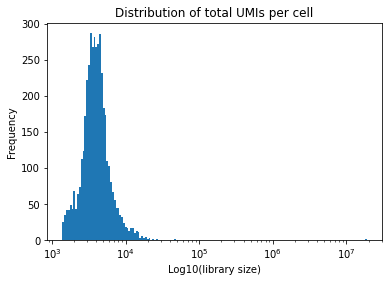

In [ ]:
#Histogram log10 of library size
last_row = df.iloc[-1]
_, bins = np.histogram(np.log10(last_row + 1), bins='auto')
plt.hist(last_row, bins=10**bins);
plt.gca().set_xscale("log")
plt.title('Distribution of total UMIs per cell')
plt.xlabel('Log10(library size)')
plt.ylabel('Frequency')

Yes, requires filtering of empty droplets that have small library sizes. But it appears this dataset has already been filtered. I will threshold at 10**(3.2) to see if the distribution changes.

In [ ]:
#Filter out cell barcodes with low library size
filtered_last_row = last_row[~(last_row < 10**(3.2))]

print('\nDataFrame Shape:', last_row.shape)
print('\nFiltered DataFrame Shape:', filtered_last_row.shape)


DataFrame Shape: (4341,)

Filtered DataFrame Shape: (4261,)


Text(0, 0.5, 'Frequency')

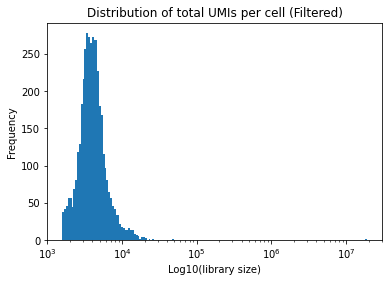

In [ ]:
#New histogram log10 of filtered library size
_, bins = np.histogram(np.log10(filtered_last_row + 1), bins='auto')
plt.hist(filtered_last_row, bins=10**bins);
plt.gca().set_xscale("log")
plt.title('Distribution of total UMIs per cell (Filtered)')
plt.xlabel('Log10(library size)')
plt.ylabel('Frequency')

In [ ]:
#Median library size before filtering
median_cells = last_row.median()
print('\nMedian library size without filtering:', median_cells)

#Median library size after filtering
median_cells_filter = filtered_last_row.median()
print('\nMedian library size with filtering:', median_cells_filter)


Median library size without filtering: 3867.0

Median library size with filtering: 3909.0


**Question 1c.**
Plot a histogram of log10 of the total number cells that each gene is expressed in. Is this distribution unimodal or multimodal? If the latter, how many genes remain if you filter the lower mode as noisy genes?

Text(0, 0.5, 'Frequency')

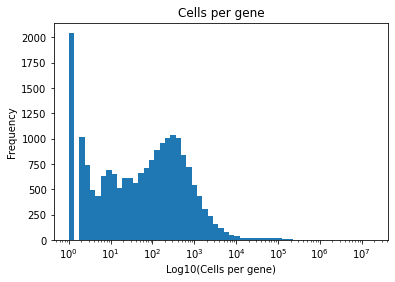

In [ ]:
#Histogram log10 of the total number of cells that each gene is expressed in
last_column = df.iloc[: , -1]
_, bins = np.histogram(np.log10(last_column + 1), bins='auto')
plt.hist(last_column, bins=10**bins);
plt.gca().set_xscale("log")
plt.title('Cells per gene')
plt.xlabel('Log10(Cells per gene)')
plt.ylabel('Frequency')


Without filtering, this looks like a bimodal distribution. I will now filter out the noisey genes.

In [ ]:
#Filter out noisey genes
filtered_last_column = last_column[~(last_column < 10**(1.4))]

print('\nDataFrame Shape:', last_column.shape)
print('\nFiltered DataFrame Shape (the number of genes remaining):', filtered_last_column.shape)


DataFrame Shape: (33695,)

Filtered DataFrame Shape (the number of genes remaining): (11931,)


Text(0, 0.5, 'Frequency')

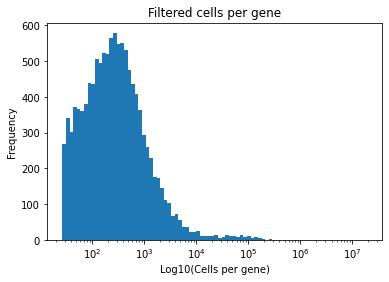

In [ ]:
#New histogram log10 with filtered out noisey genes
_, bins = np.histogram(np.log10(filtered_last_column + 1), bins='auto')
plt.hist(filtered_last_column, bins=10**bins);
plt.gca().set_xscale("log")
plt.title('Filtered cells per gene')
plt.xlabel('Log10(Cells per gene)')
plt.ylabel('Frequency')

**Question 2**
Normalize and visualize the data as follows:

In [ ]:
adata = sc.read_10x_mtx('/content/gdrive/My Drive/Statistical ML/Homework 1/pbmc4k_filtered_gene_bc_matrices/filtered_gene_bc_matrices/GRCh38/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

In [ ]:
adata.var_names_make_unique()

In [ ]:
adata #Rows correspond to cells and columns to genes.

AnnData object with n_obs × n_vars = 4340 × 33694
    var: 'gene_ids'

In [ ]:
#filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
sc.pp.calculate_qc_metrics(adata, expr_type='counts', var_type='genes', inplace= True)

In [ ]:
print(adata.var)

                      gene_ids  n_cells  ...  total_counts  log1p_total_counts
RP11-34P13.7   ENSG00000238009        9  ...           9.0            2.302585
FO538757.2     ENSG00000279457      599  ...         657.0            6.489205
AP006222.2     ENSG00000228463      235  ...         251.0            5.529429
RP4-669L17.10  ENSG00000237094       12  ...          12.0            2.564949
RP11-206L10.9  ENSG00000237491      110  ...         112.0            4.727388
...                        ...      ...  ...           ...                 ...
AL592183.1     ENSG00000273748      334  ...         361.0            5.891644
AC007325.4     ENSG00000278817       81  ...          82.0            4.418840
AL354822.1     ENSG00000278384       10  ...          10.0            2.397895
AC004556.1     ENSG00000276345       15  ...          15.0            2.772589
AC240274.1     ENSG00000271254       39  ...          40.0            3.713572

[16655 rows x 8 columns]


**Question 2a.**
Normalize the data in Q1 with global scaling to the median library size

In [ ]:
#Normalize to median of library size, or'total_counts', which is specified with target_sum= None
sc.pp.normalize_total(adata, target_sum= None)

In [ ]:
sc.pp.calculate_qc_metrics(adata, expr_type='counts', var_type='genes')

**Question 2b.**
Embed the normalized data to 2D using t-SNE or Umap or the first two principal components. Discuss the assumptions of your method of choice.

In [ ]:
#Principle Component Analysis
sc.tl.pca(adata, svd_solver='arpack')

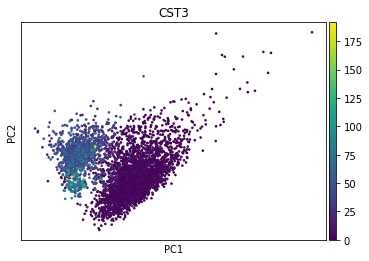

In [ ]:
sc.pl.pca(adata, color='CST3')

PCA aims to identify two main axes that capture most of the variation in the data. One assumption is that the data are independent so the observations are independent. Another assumption is that the correlation between variables are true correlations and are not biased. 

**Question 2c.**
Color cells in the embedded 2D map by log10 of library size. Interpret the plot.

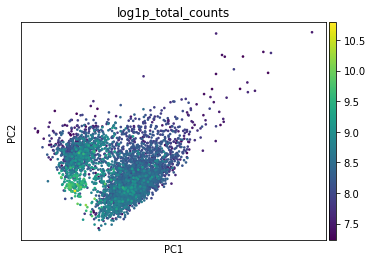

In [ ]:
#Color   cells   in   the   embedded   2D   map   by   log10   of library size
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color = 'log1p_total_counts' )

There is no clear separation in the data. The first plot was colored based on gene expression, and the colors form two separate clusters. This means there is some separation between cells based on gene expression. The second plot shows no distinct clustering based on library size. 2 principle components were not able to capture the variance here. 

**Question 3**
Regress out library size using a linear regression model (after scaling to median library size performed in Q2a) and redo Q2b-c. Explain if/why you used a regularizer.

In [ ]:
sc.pp.regress_out(adata, ['total_counts'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


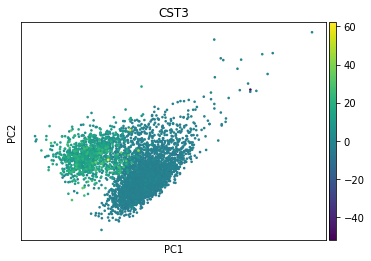

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

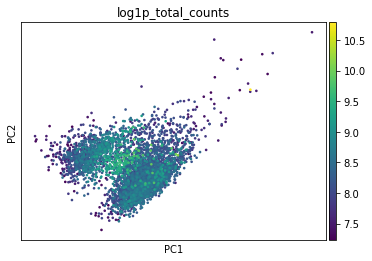

In [ ]:
#Color   cells   in   the   embedded   2D   map   by   log10   of library size
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color = 'log1p_total_counts' )

After regressing out the library size the PCA plots look similar to before. The first PCA plot, colored based on gene expression, had the best separation of colors/cells into clusters. The second plot has overlap of different library sizes within clusters and no apparent subpopulations are formed. 